#### print variable memory taken so we can delete any that we no longer need with del(variable). This notebook uses a lot of memory if run start to finish...

In [41]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          globals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      ecg_data:  1.2 GiB
        heart_rate_with_offset:  1.1 GiB
                    heart_rate:  1.1 GiB
                            df: 214.2 MiB
              features_labeled: 120.9 MiB
      cur_feature_discovery_df: 69.3 MiB
                           _29: 31.1 MiB
                           _30: 31.1 MiB
                           _18: 31.1 MiB
                           _20: 31.1 MiB


# 04 LGBM discovery
This notebook uses a light gradient boosted decision tree model to break down the different EEG, ECG, and movement features, and analyze their importances, as well as optimal settings for epoch size and hyperparameters

# Prerequisites:
- Run `make features_extended` to create features for Wednesday
- or run `python feature_generation_extended.py -i [input_edf_file] -d [output folder] -o [output_filename_prefix]` to run it on a file other than the Wednesday edf

# Table of Contents
## [Load Raw Data](#load_raw_data)
## [Compute Features v2](#compute_features_v2)
## [LGBM Grid Search](#grid_search)
## [Feature Discovery](#feature_discovery)
- ### [Movement Features](#movement_features) (not done)
- ### [ECG/Heart Rate Features](#ecg_features)
    - #### [Heart Rate Calculation](#heart_rate_calculation)
    - #### [Feature Calculation](#heart_rate_feature_calculation)
    - #### [Heart Rate Feature Plotting](#heart_rate_feature_plotting)
- ### [EEG Features](#eeg_features)
## [Read in feature discovery data](#read_feature_discovery_data)
- #### EEG
- #### ECG/Heart Rate
- #### Starter pack features v2 (includes movement and pressure features)
- #### Merge all together
## [Model Building and Testing/Analysis](#model_building_and_testing)
- ### [K-Fold Accuracy](#k_fold_accuracy)
    - #### on Sleep.Code
    - #### on Simple.Sleep.Code
- ###

In [4]:
import os
import sys
import pytz
import numpy as np
import umap
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier


sys.path.insert(0, '..') 
from src.features.feature_generation_utils import *
from src.features.feature_generation import *

In [5]:
%load_ext autoreload
%autoreload 2

<a id='load_raw_data'></a>
# Load raw data


In [6]:
# Load EDF info
path_to_edf = '../data/raw/01_edf_data/test12_Wednesday_05_ALL_PROCESSED.edf'
raw = mne.io.read_raw_edf(path_to_edf, include=['ECG_Raw_Ch1', 'EEG_ICA5', 'pitch', 'roll', 'heading',
                                                'Pressure', 'ODBA', 'GyrZ', 'MagZ'], preload=True)
info = raw.info

sfreq = info['sfreq']
edf_start_time = info['meas_date']
# Define the PST timezone
pst_timezone = pytz.timezone('America/Los_Angeles')
# Convert to datetime object in PST
if isinstance(edf_start_time, datetime.datetime):
    # If it's already a datetime object, just replace the timezone
    recording_start_datetime = edf_start_time.replace(tzinfo=None).astimezone(pst_timezone)
    # for some reason using .replace(tzinfo=...) does weird shit - offsets based of LMT instead of UTC and gets confusing
    # recording_start_datetime = edf_start_time.replace(tzinfo=pst_timezone)
elif isinstance(edf_start_time, (int, float)):
    # Convert timestamp to datetime in PST
    recording_start_datetime = pst_timezone.localize(datetime.datetime.fromtimestamp(edf_start_time))

# Load Labels
file_path = '../data/raw/02_hypnogram_data/test12_Wednesday_06_Hypnogram_JKB_1Hz.csv'
df = pd.read_csv(file_path)
df['R.Time'] = pd.to_datetime(df['R.Time']).dt.tz_localize('America/Los_Angeles')
df['Sleep.Code'].value_counts(normalize=True)


Extracting EDF parameters from /Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/data/raw/01_edf_data/test12_Wednesday_05_ALL_PROCESSED.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 158957499  =      0.000 ... 317914.998 secs...


Sleep.Code
Active Waking         0.456175
Quiet Waking          0.143221
HV Slow Wave Sleep    0.124564
Drowsiness            0.075781
Certain REM Sleep     0.072228
LV Slow Wave Sleep    0.071997
Putative REM Sleep    0.034134
Unscorable            0.021901
Name: proportion, dtype: float64

<a id='compute_features_v2'></a>
# Compute features v2

<br><br>
<b><p style='color:red'>If you have already generated the v2 features,</p><b>
## Skip to [Grid Search](#grid_search)

In [ ]:
# Load features
features_all = generate_features(path_to_edf)

In [ ]:
# Data with target, drop start and end sections that aren't scored because sensors not set up yet or taking off
features_labeled = features_all[(features_all['Time'] >= df['R.Time'].min()) &
                               (features_all['Time'] <= df['R.Time'].max())]
features_labeled = features_labeled.set_index('Time', drop=True).drop('yasa_time', axis=1)
features_labeled[['Sleep.Num', 'Simple.Sleep.Code']] = df.set_index('R.Time', drop=True)[['Sleep.Num',
                                                                                          'Simple.Sleep.Code']]
features_labeled.to_csv('../output/training_sets/Wednesday_features_v2_with_labels.csv')

<a id='grid_search'></a>
## LightGBM Grid search with v2 (start here if v2 features are already saved)

#### Read in v2 features

In [6]:
features_labeled = pd.read_csv('../data/processed/v2_features/Wednesday_features_v2_with_labels.csv')
features_labeled['Time'] = pd.to_datetime(features_labeled['Time'])
features_labeled = features_labeled.set_index('Time', drop=True)

### don't run these next four cells unless you have 8 hours, the grid search output is in the best_params dict (the last cell in this section)

In [ ]:
model_data = features_labeled.drop('Sleep.Num', axis=1).dropna()
X, y = model_data.drop('Simple.Sleep.Code', axis=1), model_data['Simple.Sleep.Code']

In [ ]:
params = {
    'learning_rate': [0.0001, 0.005, 0.01, 0.05, 0.1],
    'num_leaves': [10, 20, 40, 80],
    'n_estimators': [25, 100, 400]
}

In [ ]:
model = LGBMClassifier()
grid = GridSearchCV(model, params, scoring='f1_weighted', verbose=2, n_jobs=8)
grid.fit(X, y)

In [ ]:
grid.best_params_

In [7]:
best_params = {'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10}

<a id='feature_discovery'></a>
# Feature discovery - feature building

<a id='movement_features'></a>
## Movement features
not explored yet - just using the default values

In [ ]:
start_seconds = int((df['R.Time'].iloc[0] - recording_start_datetime).total_seconds())
end_seconds = int((df['R.Time'].iloc[-1] - recording_start_datetime).total_seconds())

In [ ]:
pitch_data = raw.get_data('pitch')[0].copy()
roll_data = raw.get_data('roll')[0].copy()
heading_data = raw.get_data('heading')[0].copy()
gyrz_data = raw.get_data('GyrZ')[0].copy()
magz_data = raw.get_data('MagZ')[0].copy()
odba_data = raw.get_data('ODBA')[0].copy()
pressure_data = raw.get_data('Pressure')[0].copy()

to_hours_factor = 60 * 60 * 500
print('Pitch', len(pitch_data) / to_hours_factor)
print('Roll', len(roll_data) / to_hours_factor)
print('Heading', len(heading_data) / to_hours_factor)
print('GyrZ', len(gyrz_data) / to_hours_factor)
print('MagZ', len(magz_data) / to_hours_factor)
print('ODBA', len(odba_data) / to_hours_factor)
print('Pressure', len(pressure_data) / to_hours_factor)

# start_index = int(start_seconds * 500)
# end_index = int(end_seconds * 500)
# ecg_data = ecg_data[start_index:end_index]

In [ ]:
def get_features_movement():
    return

In [ ]:
def generate_features_movement(raw, epoch_size_sec=32):
    """
    raw: mne raw object with 'pitch', 'roll', 'heading', 'GyrZ', 'MagZ', 'ODBA', 'Pressure' channels
    """
    return
    print(f'Generating features for epoch_size_sec={epoch_size_sec}')
    feature_dfs = []
    for i in range(0, len(ecg_data), 500 * 60 * 60):
        print (round(100 * i/len(eeg_data), 2), '% complete', sep='', end='\r')
        indices = [i, i + 500 * 60 * 60]
        indices_extra_window = [indices[0] - 500 * 60 * 5, indices[1] + 500 * 60 * 5]
        if indices_extra_window[0] < 0:
            indices_extra_window[0] = 0
        if indices_extra_window[1] > len(eeg_data):
            indices_extra_window[1] = len(eeg_data)
        if indices[1] > len(eeg_data):
            indices[1] = len(eeg_data)

        eeg_subset = eeg_data[indices_extra_window[0]:indices_extra_window[1]]
        features_subset = get_features_yasa(eeg_subset, epoch_window_sec=epoch_size_sec, sfreq=500,
                                            freq_broad=(0, 30), welch_window_sec=welch_window_sec, step_size=1)
        start_offset = indices_extra_window[0] // 500
        features_subset['yasa_time'] = df['R.Time'].iloc[0] + pd.to_timedelta(
            features_subset['epoch_index'] + start_offset, unit='s'
        )
        features_subset = features_subset.drop('epoch_index', axis=1)
        df_start_idx = (indices[0] - indices_extra_window[0]) // 500
        df_end_idx = (indices[1] - indices_extra_window[0]) // 500
        feature_dfs.append(features_subset.iloc[df_start_idx:df_end_idx])
    print('100% complete')
    features_df = pd.concat(feature_dfs)
    return features_df 

<a id='ecg_features'></a>
## ECG features

<a id='heart_rate_calculation'></a>
### Load ECG and compute heart rate, verify with LabChart

In [8]:
start_seconds = int((df['R.Time'].iloc[0] - recording_start_datetime).total_seconds())
end_seconds = int((df['R.Time'].iloc[-1] - recording_start_datetime).total_seconds())

In [9]:
ecg_data = raw.get_data('ECG_Raw_Ch1')[0].copy()
start_index = int(start_seconds * 500)
end_index = int(end_seconds * 500)
offset = 300 # 5 minutes
start_index_with_offset = start_index - offset * 500 if start_index - offset * 500 > 0 else 0
end_index_with_offset = end_index + offset * 500 if end_index + offset * 500 < len(ecg_data) else len(ecg_data)
ecg_with_offset = ecg_data[start_index_with_offset : end_index_with_offset]
start_buffer = int(start_index - start_index_with_offset)
end_buffer = int(end_index_with_offset - end_index)

In [10]:
heart_rate_with_offset = get_heart_rate(ecg_with_offset, fs=sfreq, search_radius=200, filter_threshold=200)

/Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/notebooks/../src/features/feature_generation_utils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  heart_rates = [60 / ((rpeaks_corrected[i+1] - rpeaks_corrected[i]) / fs) for i in range(len(rpeaks_corrected) - 1)]


Filled: 0


In [11]:
heart_rate = heart_rate_with_offset.iloc[start_buffer:-end_buffer+1]
heart_rate_1hz = [heart_rate.iloc[i] for i in range(0, len(heart_rate), 500)]

In [12]:
heart_rate_timed = pd.Series(heart_rate_1hz, index=df['R.Time'])

(0.0, 100.0)

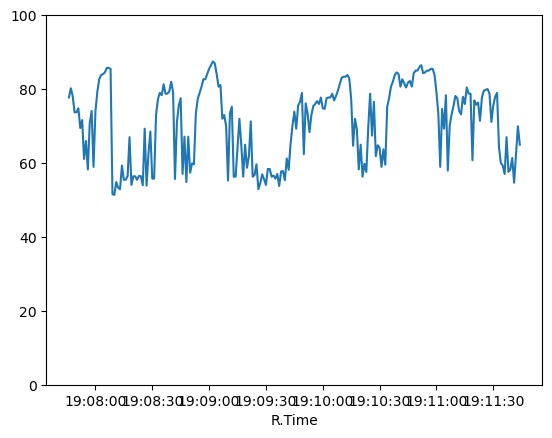

In [15]:
rem_sec = (
    datetime.datetime.strptime('10/25/2019 19:07:45', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone),
    datetime.datetime.strptime('10/25/2019 19:11:45', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone)
)
sns.lineplot(heart_rate_timed[(heart_rate_timed.index > rem_sec[0]) & (heart_rate_timed.index < rem_sec[1])])
plt.ylim(0, 100)

<b>This matches the labchart heart rate trend line for this section, although the heart rate values differ slightly</b>

<a id='heart_rate_feature_calculation'></a>
### Generate ECG features

In [16]:
def get_hr_spectral_power_epoched(heart_rate_data, sfreq=500, ref_power=1, epoch_window_sec=256,
                                  welch_window_sec=256, step_size=8):
    import antropy as ant
    import scipy.signal as sp_sig
    import scipy.stats as sp_stats
    from yasa import sliding_window
    from yasa import bandpower_from_psd_ndarray
    from mne.filter import filter_data
    
    dt_filt = filter_data(
        heart_rate_data, sfreq, l_freq=0, h_freq=1, verbose=False
    )
    
    # - Extract epochs. Data is now of shape (n_epochs, n_samples).
    times, epochs = sliding_window(dt_filt, sf=sfreq, window=epoch_window_sec, step=step_size)
    times = times + epoch_window_sec // 2 # add window/2 to the times to make the epochs "centered" around the times
    
    window_length = sfreq*welch_window_sec
    kwargs_welch = dict(
        window='hann',
        nperseg=window_length, # a little more than  4 minutes
        noverlap=window_length//2,
        scaling='density',
        average='median'
    )
    bands = [
        (0.0033, 0.04, 'vlf'),
        (0.04, 0.15, 'lf'),
        (0.15, 0.4, 'hf')
    ]
    freqs, psd = sp_sig.welch(epochs, sfreq, **kwargs_welch)
    bp = bandpower_from_psd_ndarray(psd, freqs, bands=bands)
    
    feat = {}
    
    # Calculate standard descriptive statistics
    hmob, hcomp = ant.hjorth_params(epochs, axis=1)
    
    feat = {
        "mean": np.mean(epochs, axis=1),
        "std": np.std(epochs, ddof=1, axis=1),
        "iqr": sp_stats.iqr(epochs, rng=(25, 75), axis=1),
        "skew": sp_stats.skew(epochs, axis=1),
        "kurt": sp_stats.kurtosis(epochs, axis=1),
        "hmob": hmob,
        "hcomp": hcomp,
    }
    
    # Bandpowers
    for j, (_, _, b) in enumerate(bands):
        feat[b] = bp[j]

    feat['lf/hf'] = feat['lf'] / feat['hf']
    feat['p_total'] = feat['vlf'] + feat['lf'] + feat['hf']

    # compute relative and normalized power measures
    perc_factor = 100 / feat['p_total']
    feat['vlf_perc'] = feat['vlf'] * perc_factor
    feat['lf_perc'] = feat['lf'] * perc_factor
    feat['hf_perc'] = feat['hf'] * perc_factor

    nu_factor = 100 / (feat['lf'] + feat['hf'])
    feat['lf_nu'] = feat['lf'] * nu_factor
    feat['hf_nu'] = feat['hf'] * nu_factor

    # Convert to dataframe
    feat = pd.DataFrame(feat)
    col_rename_map = {}
    for col in feat.columns:
        feat[col] = pd.to_numeric(feat[col])
        col_rename_map[col] = 'HR_' + col
    feat = feat.rename(col_rename_map, axis=1)
    
    feat["epoch_index"] = times # added window / 2 to the times above to center the epochs on the times
    return feat


In [451]:
def generate_features_heart_rate(heart_rate_data, offset=300, epoch_size_sec=128, welch_window_sec=64,
                                 step_size=8):
    print(f'Generating features for epoch_size_sec={epoch_size_sec} and welch_window_sec={welch_window_sec}')
    # Start at "0", with the first epoch being centered around the first label
    feature_dfs = []
    for i in range(offset * 500, len(heart_rate_data), 500 * 60 * 60):
        #print (round(100 * i/len(heart_rate_data), 2), '% complete', sep='', end='\r')
        indices = [i, i + 500 * 60 * 60]
        indices_extra_window = [indices[0] - 500 * 60 * 5, indices[1] + 500 * 60 * 5]
        if indices_extra_window[0] < 0:
            indices_extra_window[0] = 0
        if indices_extra_window[1] > len(heart_rate_data):
            indices_extra_window[1] = len(heart_rate_data)
        if indices[1] > len(heart_rate_data):
            indices[1] = len(heart_rate_data)
        heart_rate_subset = heart_rate_data[indices_extra_window[0]:indices_extra_window[1]]
        features_subset = get_hr_spectral_power_epoched(heart_rate_subset, epoch_window_sec=epoch_size_sec,
                                                        welch_window_sec=welch_window_sec, step_size=step_size)
        # subtract the start buffer length (the section of ecg passed included that isn't scored, but is used in
        # in the epoch window) from the yasa epoch
        start_offset = indices_extra_window[0] // 500
        start_idx = indices[0] // 500 - offset
        end_idx = indices[1] // 500 - offset
        features_subset['epoch_index'] = (features_subset['epoch_index'] + start_offset - offset).astype(int)
        features_subset = features_subset[
            (features_subset['epoch_index'] >= start_idx) &
            (features_subset['epoch_index'] < end_idx)
        ]
        print(str(round(100 * i/len(eeg_data), 2)) + '% complete', 
             features_subset['epoch_index'].iloc[0],
             features_subset['epoch_index'].iloc[-1], end='\r')
        feature_dfs.append(features_subset)
    print('100.00% complete' + ' '*20)
    print()
    features_df = pd.concat(feature_dfs).drop_duplicates(subset='epoch_index', keep='first')
    features_df['yasa_time'] = df['R.Time'].iloc[0] + pd.to_timedelta(features_df['epoch_index'], unit='s')

    # Ffill and Bfill for if step size is >1 second
    fill_limit = step_size // 2
    features_df = (
        features_df.set_index('yasa_time', drop=True).sort_index().resample('1S')
        .ffill(limit=fill_limit).bfill(limit=fill_limit+1)
    ).reset_index()
    return features_df

In [452]:
test_hr_feature_df = generate_features_heart_rate(heart_rate_with_offset.values, offset=300, epoch_size_sec=128,
                                                  welch_window_sec=64, step_size=128 // 8)

Generating features for epoch_size_sec=128 and welch_window_sec=64
100.00% complete                    



<a id='heart_rate_feature_plotting'></a>
### Plot a few naps to verify validity

In [471]:
features_v2_with_hr_features = test_hr_feature_df.set_index('yasa_time', drop=True).merge(
    df.set_index('R.Time', drop=True)[['Simple.Sleep.Code']], left_index=True, right_index=True, how='right'
).ffill(limit=128 // 8).bfill(limit=128 // 8)

In [486]:
def plot_nap_hr_features(nap):
    ecg_subset = ecg_data[start_index:end_index]
    start_time = (nap[0] - df['R.Time'].iloc[0]).total_seconds()
    end_time = (nap[1] - df['R.Time'].iloc[0]).total_seconds()
    fig, ax = plt.subplots(8, figsize=(8, 11))
    subset_times = df['R.Time'][df['R.Time'].between(nap[0], nap[1])]
    hr_features_nap = features_v2_with_hr_features[(features_v2_with_hr_features.index > nap[0]) & 
                                                   (features_v2_with_hr_features.index < nap[1])]
    sns.lineplot(hr_features_nap['Simple.Sleep.Code'], ax=ax[0])
    sns.lineplot(ecg_subset[int(start_time*500):int(end_time*500)], ax=ax[1], linewidth=0.1)
    ax[1].set_ylabel('ECG_Raw_Ch1')
    sns.lineplot(heart_rate_1hz[subset_times.index[0]:subset_times.index[-1]], ax=ax[2])
    ax[2].set_ylabel('Heart Rate')
    sns.lineplot(hr_features_nap['HR_mean'], ax=ax[3])
    sns.lineplot(hr_features_nap['HR_std'].rename('NEW std'), ax=ax[4])
    sns.lineplot(hr_features_nap['HR_vlf'].rename('NEW vlf'), ax=ax[5])
    sns.lineplot(hr_features_nap['HR_lf'].rename('NEW lf'), ax=ax[6])
    sns.lineplot(hr_features_nap['HR_hf'].rename('NEW hf'), ax=ax[7])
    plt.show()

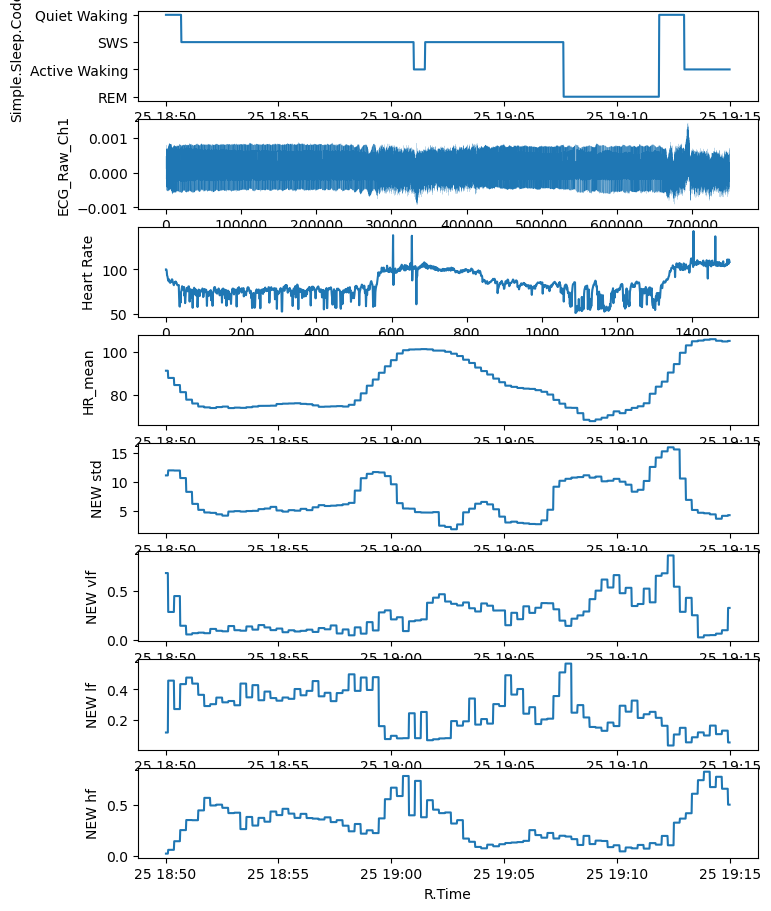

In [487]:
nap1 = (
    datetime.datetime.strptime('10/25/2019 18:50:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone),
    datetime.datetime.strptime('10/25/2019 19:15:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone)
)
plot_nap_hr_features(nap1)

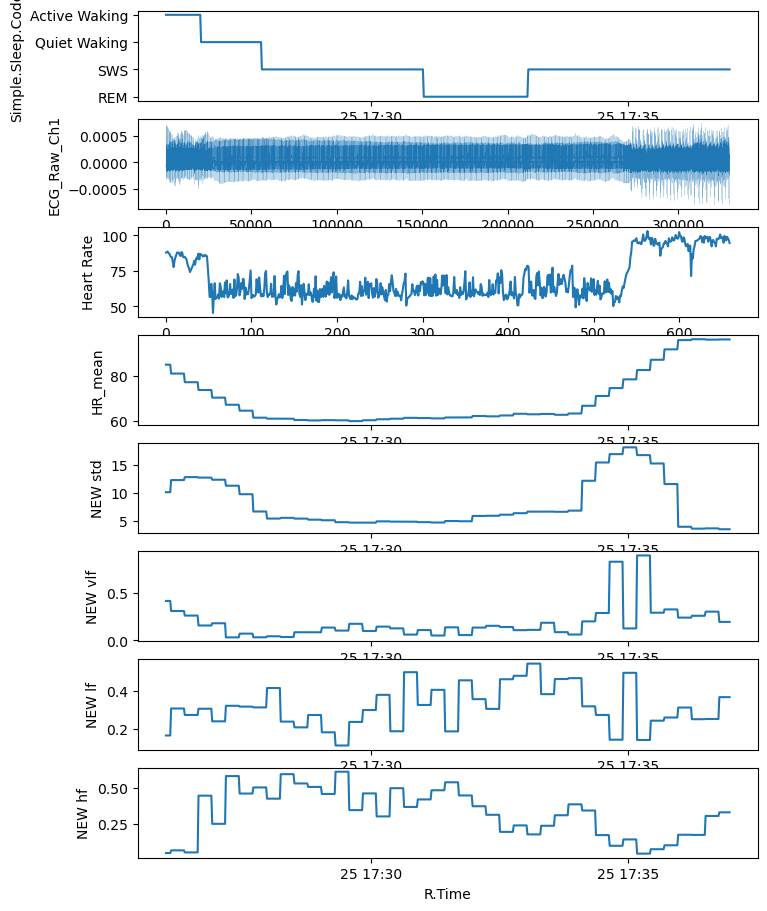

In [488]:
nap2 = (
    datetime.datetime.strptime('10/25/2019 17:26:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone),
    datetime.datetime.strptime('10/25/2019 17:37:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone)
)
plot_nap_hr_features(nap2)

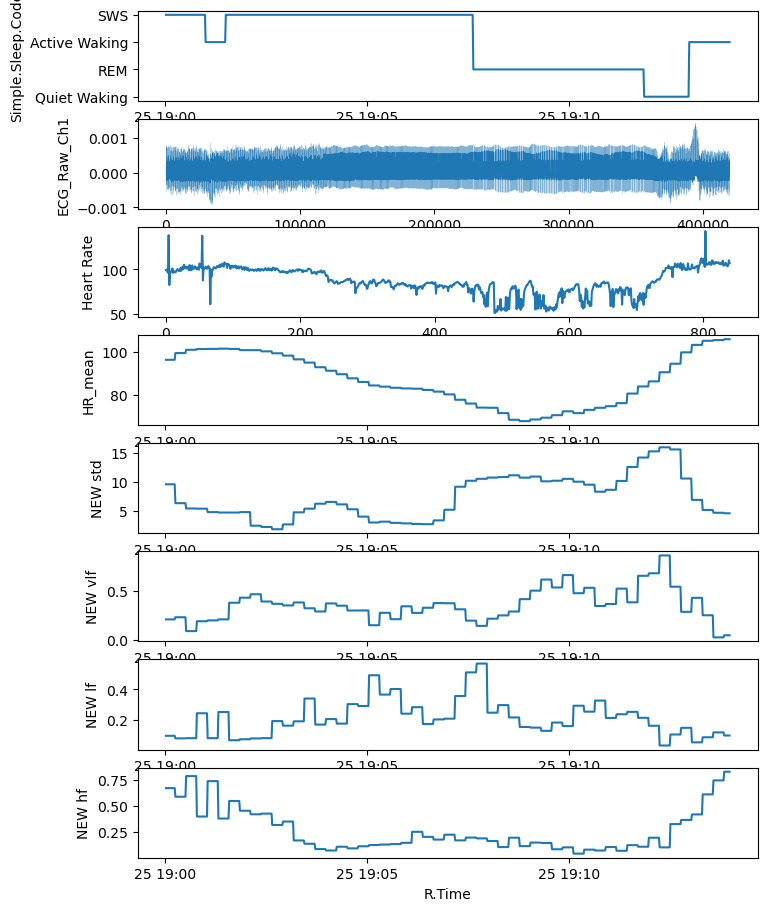

In [489]:
nap3 = (
    datetime.datetime.strptime('10/25/2019 19:00:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone),
    datetime.datetime.strptime('10/25/2019 19:14:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone)
)
plot_nap_hr_features(nap3)

#### Generate and save Heart Rate features for every welch window size and epoch size

In [490]:
os.makedirs('../data/interim/feature_discovery/ECG', exist_ok=True)
for epoch_window_sec in [128, 256, 512]:
    for welch_window_sec in [64, 128, 256, 512]:
        if welch_window_sec > epoch_window_sec:
            continue
        hr_features = generate_features_heart_rate(heart_rate_with_offset.values, welch_window_sec=welch_window_sec,
                                                   epoch_size_sec=epoch_window_sec, step_size=epoch_window_sec//8)
        hr_features = hr_features.set_index('yasa_time').merge(
            df.set_index('R.Time')[['Simple.Sleep.Code']], left_index=True, right_index=True
        )
        file_str = f'Wednesday_features_ECG_v3_EPOCH_{epoch_window_sec}_WELCH_{welch_window_sec}.csv'
        hr_features.to_csv(f'../data/interim/feature_discovery/ECG/{file_str}')

Generating features for epoch_size_sec=128 and welch_window_sec=64
100.00% complete                    

Generating features for epoch_size_sec=128 and welch_window_sec=128
100.00% complete                    

Generating features for epoch_size_sec=256 and welch_window_sec=64
100.00% complete                    

Generating features for epoch_size_sec=256 and welch_window_sec=128
100.00% complete                    

Generating features for epoch_size_sec=256 and welch_window_sec=256
100.00% complete                    

Generating features for epoch_size_sec=512 and welch_window_sec=64
100.00% complete                    

Generating features for epoch_size_sec=512 and welch_window_sec=128
100.00% complete                    

Generating features for epoch_size_sec=512 and welch_window_sec=256
100.00% complete                    

Generating features for epoch_size_sec=512 and welch_window_sec=512
100.00% complete                    



<a id='eeg_features'></a>
## EEG features

In [13]:
start_seconds = int((df['R.Time'].iloc[0] - recording_start_datetime).total_seconds())
end_seconds = int((df['R.Time'].iloc[-1] - recording_start_datetime).total_seconds())
eeg_data = raw.get_data('EEG_ICA5')[0].copy()
start_index = int(start_seconds * 500)
end_index = int(end_seconds * 500)
eeg_data = eeg_data[start_index:end_index]

In [340]:
def get_eeg_features_yasa(a, epoch_window_sec=32, sfreq=500, freq_broad=(0, 30), welch_window_sec=2,
                          step_size=1):
    import numpy as np
    import pandas as pd
    import antropy as ant
    import scipy.signal as sp_sig
    import scipy.stats as sp_stats
    import matplotlib.pyplot as plt
    from mne.filter import filter_data
    from sklearn.preprocessing import robust_scale
    from yasa import sliding_window
    from yasa import bandpower_from_psd_ndarray
    
    # Welch keyword arguments
    
    kwargs_welch = dict(window="hamming", nperseg=welch_window_sec*sfreq, average="median")
    bands = [
        (0, 0.5, 'BP_0_0.5'),
        (0.5, 1, 'BP_0.5_1'),
    ] + [ (i, i+1, f'BP_{i}_{i+1}') for i in range(1, 30)]
    #  Preprocessing
    # - Filter the data
    dt_filt = filter_data(
        a, sfreq, l_freq=freq_broad[0], h_freq=freq_broad[1], verbose=False
    )

    # - Extract epochs. Data is now of shape (n_epochs, n_samples).
    times, epochs = sliding_window(dt_filt, sf=sfreq, window=epoch_window_sec, step=step_size)
    times = times + epoch_window_sec // 2
    
    # Calculate spectral power features (for EEG + EOG)
    freqs, psd = sp_sig.welch(epochs, sfreq, **kwargs_welch)
    bp = bandpower_from_psd_ndarray(psd, freqs, bands=bands)
    
    feat = {}
    # Calculate standard descriptive statistics
    hmob, hcomp = ant.hjorth_params(epochs, axis=1)
    
    feat = {
        "mean": np.mean(epochs, axis=1),
        "std": np.std(epochs, ddof=1, axis=1),
        "iqr": sp_stats.iqr(epochs, rng=(25, 75), axis=1),
        "skew": sp_stats.skew(epochs, axis=1),
        "kurt": sp_stats.kurtosis(epochs, axis=1),
        "nzc": ant.num_zerocross(epochs, axis=1),
        "hmob": hmob,
        "hcomp": hcomp,
    }
    
    # bandpowers
    for j, (_, _, b) in enumerate(bands):
        feat[b] = bp[j]

    # Add total power
    idx_broad = np.logical_and(freqs >= freq_broad[0], freqs <= freq_broad[1])
    dx = freqs[1] - freqs[0]
    feat['abspow'] = np.trapz(psd[:, idx_broad], dx=dx)
    
    # Calculate entropy and fractal dimension features
    feat["perm"] = np.apply_along_axis(ant.perm_entropy, axis=1, arr=epochs, normalize=True)
    feat["higuchi"] = np.apply_along_axis(ant.higuchi_fd, axis=1, arr=epochs)
    feat["petrosian"] = ant.petrosian_fd(epochs, axis=1)
    
    # Add power ratios for EEG and make each feature relative to absolute power
    for key in list(feat.keys()):
        if key != 'abspow':
            feat[key + '_relative'] = feat[key] / feat['abspow']

    # Convert to dataframe
    feat = pd.DataFrame(feat)
    
    # Add EEG_ prefix to columns
    col_rename_map = {}
    for col in feat.columns:
        feat[col] = pd.to_numeric(feat[col])
        col_rename_map[col] = 'EEG_' + col
    feat = feat.rename(col_rename_map, axis=1)
    
    feat["epoch_index"] = times # Added window/2 above to center the times in the middle of the epoch
    
    return feat

### create windows of 1hr with 5 minute buffers before and after, then concatenate each window together (but cutting out the buffer)
so we don't run out of memory ;(

In [344]:
def generate_features_eeg(eeg_data, epoch_size_sec=32, welch_window_sec=2, step_size=1,
                          datetime_starttime=df['R.Time'].iloc[0]):
    print(f'Generating features for epoch_size_sec={epoch_size_sec} and welch_window_sec={welch_window_sec}')
    feature_dfs = []
    for i in range(0, len(eeg_data), 500 * 60 * 60):
        indices = [i, i + 500 * 60 * 60]
        indices_extra_window = [indices[0] - 500 * 60 * 5, indices[1] + 500 * 60 * 5]
        if indices_extra_window[0] < 0:
            indices_extra_window[0] = 0
        if indices_extra_window[1] > len(eeg_data):
            indices_extra_window[1] = len(eeg_data)
        if indices[1] > len(eeg_data):
            indices[1] = len(eeg_data)

        eeg_subset = eeg_data[indices_extra_window[0]:indices_extra_window[1]]
        features_subset = get_eeg_features_yasa(eeg_subset, epoch_window_sec=epoch_size_sec, sfreq=500,
                                                freq_broad=(0, 30), welch_window_sec=welch_window_sec,
                                                step_size=step_size)
        start_offset = indices_extra_window[0] // 500
        start_idx = indices[0] // 500
        end_idx = indices[1] // 500
        features_subset['epoch_index'] = (features_subset['epoch_index'] + start_offset).astype(int)
        features_subset = features_subset[
            (features_subset['epoch_index'] >= start_idx) &
            (features_subset['epoch_index'] < end_idx)
        ]
        print(str(round(100 * i/len(eeg_data), 2)) + '% complete',
              features_subset['epoch_index'].iloc[0],
              features_subset['epoch_index'].iloc[-1], end='\r')
        feature_dfs.append(features_subset)
    print('100.00% complete' + ' '*20)
    features_df = pd.concat(feature_dfs)
    features_df['yasa_time'] = datetime_starttime + pd.to_timedelta(features_df['epoch_index'], unit='s')
    features_df = features_df.drop('epoch_index', axis=1)
    return features_df

#### Generate and save EEG features for every welch window size and epoch size

In [343]:
os.makedirs('../data/interim/feature_discovery/EEG', exist_ok=True)
warnings.simplefilter('ignore')
start_seconds = int((df['R.Time'].iloc[0] - recording_start_datetime).total_seconds())
end_seconds = int((df['R.Time'].iloc[-1] - recording_start_datetime).total_seconds())
eeg_data = raw.get_data('EEG_ICA5')[0].copy()
start_index = int(start_seconds * 500)
end_index = int(end_seconds * 500)
eeg_data = eeg_data[start_index:end_index]
for welch_window_sec in [1, 2, 4, 8, 16]:
    for epoch_window_sec in [16, 32, 64, 128, 256]:
        welch_str = f'WELCH_{welch_window_sec}'
        epoch_str = f'EPOCH_{epoch_window_sec}'
        print(f'{epoch_str}_{welch_str}')
        if epoch_window_sec < welch_window_sec:
            print('Epoch less than Welch window size, continuing...')
            continue
        step_size = epoch_window_sec//8
        file_str = f'Wednesday_features_EEG_v3_{epoch_str}_{welch_str}.csv'
        features_df = generate_features_eeg(eeg_data, epoch_size_sec=epoch_window_sec,
                                            welch_window_sec=welch_window_sec,
                                            step_size=step_size, datetime_starttime=df['R.Time'].iloc[0])
        features_with_labels_df = features_df.set_index('yasa_time').merge(
            df.set_index('R.Time')[['Simple.Sleep.Code']], left_index=True, right_index=True, how='right'
        )
        fill_limit = step_size // 2
        features_with_labels_df = (
            features_with_labels_df.resample('1s').ffill(limit=fill_limit).bfill(limit=fill_limit)
            .reset_index(names='yasa_time')
        )
        features_with_labels_df.to_csv(f'../data/interim/feature_discovery/EEG/{file_str}', index=False)

EPOCH_16_WELCH_1
Generating features for epoch_size_sec=16 and welch_window_sec=1
100.00% complete291600 294682
EPOCH_32_WELCH_1
Generating features for epoch_size_sec=32 and welch_window_sec=1
100.00% complete291600 294672
EPOCH_64_WELCH_1
Generating features for epoch_size_sec=64 and welch_window_sec=1
100.00% complete291604 294652
EPOCH_128_WELCH_1
Generating features for epoch_size_sec=128 and welch_window_sec=1
100.00% complete291604 294612
EPOCH_256_WELCH_1
Generating features for epoch_size_sec=256 and welch_window_sec=1
100.00% complete291620 294532
EPOCH_16_WELCH_2
Generating features for epoch_size_sec=16 and welch_window_sec=2
100.00% complete291600 294682
EPOCH_32_WELCH_2
Generating features for epoch_size_sec=32 and welch_window_sec=2
100.00% complete291600 294672
EPOCH_64_WELCH_2
Generating features for epoch_size_sec=64 and welch_window_sec=2
100.00% complete291604 294652
EPOCH_128_WELCH_2
Generating features for epoch_size_sec=128 and welch_window_sec=2
100.00% complete

<a id='read_feature_discovery_data'></a>
## Read in Movement, ECG, and EEG features and join them together for feature discovery
basically just figuring out which settings (e.g. epoch size in seconds, welch window size for power spectral density, etc.) for each feature are the best representation of differences between sleep states.

#### Read EEG features

In [8]:
import re
all_combined_eeg = []
feature_discovery_dir = '../data/interim/feature_discovery/EEG/'

total_files = len(os.listdir(feature_discovery_dir))
for i, file in enumerate([file for file in os.listdir(feature_discovery_dir) if '.csv' in file]):
#     try:
    print(f'{100*i/total_files:.2f}% complete', end='\r')
    if file[0] not in ['.', '_']:
        welch_num = int(re.findall('WELCH_[0-9]+', file)[0][6:])
        epoch_num = int(re.findall('EPOCH_[0-9]+', file)[0][6:])
        cur_feature_discovery_df = pd.read_csv(feature_discovery_dir + file, index_col=0)
        if 'Simple.Sleep.Code' in cur_feature_discovery_df.columns:
            cur_feature_discovery_df = cur_feature_discovery_df.drop('Simple.Sleep.Code', axis=1)
        for col in cur_feature_discovery_df.columns:
            cur_feature_discovery_df[col] = pd.to_numeric(cur_feature_discovery_df[col])
        col_rename_map = {}
        for col in cur_feature_discovery_df.columns:
            col_rename_map[col] = f'EPOCH_{epoch_num}_WELCH_{welch_num}_{col}'
        cur_feature_discovery_df = cur_feature_discovery_df.rename(col_rename_map, axis=1)
        all_combined_eeg.append(cur_feature_discovery_df)
#     except:
#         print('Failed to get epoch or welch number from:', file)
print('100.00% complete')
all_combined_eeg_df = pd.concat(all_combined_eeg, axis=1)
all_combined_eeg_df.index = pd.to_datetime(all_combined_eeg_df.index)
all_combined_eeg_df.columns = all_combined_eeg_df.columns.str.replace(' ', '_')
if False: # change to True if you want to write to file again
    print('Writing EEG features to file...')
    (
        all_combined_eeg_df.join(features_labeled[['Simple.Sleep.Code']])
        .to_csv('../data/processed/v3_features/Wednesday_eeg_features_with_labels_v3.csv')
    )
    print('Done')
model_data_v3 = all_combined_eeg_df.dropna().copy()
del(all_combined_eeg_df)
del(all_combined_eeg)

100.00% complete
Writing EEG features to file...
Done


#### Read ECG features

In [9]:
import re
all_combined_ecg = []
feature_discovery_dir = '../data/interim/feature_discovery/ECG/'

total_files = len(os.listdir(feature_discovery_dir))
for i, file in enumerate([file for file in os.listdir(feature_discovery_dir) if '.csv' in file]):
#     try:
    print(f'{100*i/total_files:.2f}% complete', end='\r')
    if file[0] not in ['.', '_']:
        welch_num = int(re.findall('WELCH_[0-9]+', file)[0][6:])
        epoch_num = int(re.findall('EPOCH_[0-9]+', file)[0][6:])
        cur_feature_discovery_df = pd.read_csv(feature_discovery_dir + file, index_col=0)
        if 'Simple.Sleep.Code' in cur_feature_discovery_df.columns:
            cur_feature_discovery_df = cur_feature_discovery_df.drop('Simple.Sleep.Code', axis=1)
        
        # Make columns numeric
        for col in cur_feature_discovery_df.columns:
            cur_feature_discovery_df[col] = pd.to_numeric(cur_feature_discovery_df[col])
        col_rename_map = {}
        
        # Rename columns with the epoch and welch size in the column name
        for col in cur_feature_discovery_df.columns:
            col_rename_map[col] = f'EPOCH_{epoch_num}_WELCH_{welch_num}_{col}'
        cur_feature_discovery_df = cur_feature_discovery_df.rename(col_rename_map, axis=1)
        all_combined_ecg.append(cur_feature_discovery_df)
#     except:
#         print('Failed to get epoch or welch number from:', file)
print('100.00% complete')
all_combined_ecg_df = pd.concat(all_combined_ecg, axis=1)
all_combined_ecg_df.index = pd.to_datetime(all_combined_ecg_df.index)
all_combined_ecg_df.columns = all_combined_ecg_df.columns.str.replace(' ', '_')
if False: # change to True if you want to write to file again
    print('Writing ECG features to file...')
    all_combined_ecg_df.to_csv('../data/processed/v3_features/Wednesday_ecg_features_with_labels_v3.csv')
    print('Done')
model_data_v3 = model_data_v3.join(all_combined_ecg_df).dropna().copy()
del(all_combined_ecg_df)
del(all_combined_ecg)

100.00% complete


#### Merge with starter pack features and Simple.Sleep.Code

In [10]:
model_data_v3 = model_data_v3.join(features_labeled[[
    'Heart Rate', 'Heart Rate Mean', 'Heart Rate Std.Dev',
    'Heart Rate Very Low Frequency Power', 'Heart Rate VLF Power Std.Dev',
    'Pressure Mean', 'Pressure Std.Dev', 'ODBA Mean', 'ODBA Std.Dev',
    'GyrZ Mean', 'GyrZ Std.Dev', 'Simple.Sleep.Code'
]])
model_data_v3.columns = model_data_v3.columns.str.replace(' ', '_')

In [45]:
model_data_v3.to_csv('../data/processed/v3_features/Wednesday_all_features_with_labels_v3.csv')

<a id='model_building_and_testing'></a>
# Model Building and Testing/Analysis

#### Jupyter caches the history of a variable in memory so this clears that

In [46]:
if model_data_v3 is not None:
    del(model_data_v3)
model_data_v3 = pd.read_csv('../data/processed/v3_features/Wednesday_all_features_with_labels_v3.csv',
                            index_col=0)
model_data_v3.index = pd.DatetimeIndex(model_data_v3.index, tz=pst_timezone)

<a id='get_feature_importance'></a>
### Get feature importance and test accuracy

In [47]:
model_data_v3['Simple.Sleep.Code'].value_counts()

Simple.Sleep.Code
Active Waking    133121
SWS               57374
Quiet Waking      41896
REM               31073
Drowsiness        22225
Unscorable         6367
Name: count, dtype: int64

In [48]:
model_data_v3.columns

Index(['EPOCH_32_WELCH_1_EEG_mean', 'EPOCH_32_WELCH_1_EEG_std',
       'EPOCH_32_WELCH_1_EEG_iqr', 'EPOCH_32_WELCH_1_EEG_skew',
       'EPOCH_32_WELCH_1_EEG_kurt', 'EPOCH_32_WELCH_1_EEG_nzc',
       'EPOCH_32_WELCH_1_EEG_hmob', 'EPOCH_32_WELCH_1_EEG_hcomp',
       'EPOCH_32_WELCH_1_EEG_BP_0_0.5', 'EPOCH_32_WELCH_1_EEG_BP_0.5_1',
       ...
       'Heart_Rate_Std.Dev', 'Heart_Rate_Very_Low_Frequency_Power',
       'Heart_Rate_VLF_Power_Std.Dev', 'Pressure_Mean', 'Pressure_Std.Dev',
       'ODBA_Mean', 'ODBA_Std.Dev', 'GyrZ_Mean', 'GyrZ_Std.Dev',
       'Simple.Sleep.Code'],
      dtype='object', length=2290)

#### Build model with LGBMClassifier

In [11]:
X, y = model_data_v3.drop('Simple.Sleep.Code', axis=1), model_data_v3['Simple.Sleep.Code']
best_params = {'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10}
feature_discovery_model = LGBMClassifier(**best_params, n_jobs=8)
feature_discovery_model.fit(X, y)
feat_importances_all_combined = pd.Series(feature_discovery_model.feature_importances_,
                                          index=feature_discovery_model.feature_name_)
feat_importances_all_combined = feat_importances_all_combined.rename('feature_importance')
feat_importances_all_combined.index = feat_importances_all_combined.index.rename('feature')
feat_importances_all_combined.to_csv('../data/processed/v3_features/Wednesday_feature_importance_v3.csv')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.499438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 578595
[LightGBM] [Info] Number of data points in the train set: 292056, number of used features: 2269
[LightGBM] [Info] Start training from score -0.785687
[LightGBM] [Info] Start training from score -2.575728
[LightGBM] [Info] Start training from score -1.941755
[LightGBM] [Info] Start training from score -2.240606
[LightGBM] [Info] Start training from score -1.627354
[LightGBM] [Info] Start training from score -3.825817


### Save model as pkl with joblib

In [50]:
import joblib
# save model
joblib.dump(feature_discovery_model, '../models/lightgbm_model_extended_features.pkl')
# load model
# feat_imp_model_pkl_loaded = joblib.load('../output/models/lightgbm_model_extended_features.pkl')

['../models/lightgbm_model_welch_epoch_discovery.pkl']

### Save feature data with only used features
(everything with feature importance > 0)

In [51]:
only_used_df = model_data_v3[
    list(feat_importances_all_combined[feat_importances_all_combined > 0].index) + ['Simple.Sleep.Code']
]
only_used_df.to_csv('../data/processed/v3_features/Wednesday_used_features_with_labels_v3.csv')

In [52]:
del(model_data_v3)

<a id='k_fold_accuracy'></a>
## Test accuracy of model with 5-fold cross validation

### Test on Sleep.Code
This has the following sleep codes:
- Active Waking
- Quiet Waking
- Drowsiness
- LV Slow Wave Sleep
- HV Slow Wave Sleep
- Putative REM Sleep
- Certain REM Sleep
- Unscorable

In [53]:
complex_sleep_code_df = (
    only_used_df.drop('Simple.Sleep.Code', axis=1)
    .join(df.set_index('R.Time', drop=True)[['Sleep.Code']]).copy()
)

In [54]:
complex_sleep_code_df['Sleep.Code'].value_counts(normalize=True)[
    ['Active Waking', 'Quiet Waking', 'Drowsiness', 'LV Slow Wave Sleep', 'HV Slow Wave Sleep',
     'Putative REM Sleep', 'Certain REM Sleep', 'Unscorable']
]

Sleep.Code
Active Waking         0.455806
Quiet Waking          0.143452
Drowsiness            0.076098
LV Slow Wave Sleep    0.071729
HV Slow Wave Sleep    0.124719
Putative REM Sleep    0.033946
Certain REM Sleep     0.072448
Unscorable            0.021801
Name: proportion, dtype: float64

In [55]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

best_params = {'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10}

# Initialize k-fold
n_splits = 5  # Define the number of splits for k-fold
skf = KFold(n_splits=n_splits, shuffle=False)

# Initialize arrays to store accuracies
class_accuracies_complex = []
overall_accuracies_complex = []

X, y = complex_sleep_code_df.drop('Sleep.Code', axis=1), complex_sleep_code_df['Sleep.Code']
kfold_preds_complex = []
# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f'Fold {fold + 1}/{n_splits}')
    kmodel_complex = LGBMClassifier(**best_params, n_jobs=8)
    
    X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model without unscorable so we can see what it predicts it as
    train_filter = y_tr != 'Unscorable'
    X_tr, y_tr = X_tr.loc[train_filter], y_tr.loc[train_filter]
    
    # Train the model
    kmodel_complex.fit(X_tr, y_tr)
    
    # Predict on validation set
    y_pred_complex = pd.Series(kmodel_complex.predict(X_val), index=y_val.index)
    kfold_preds_complex.append(y_pred_complex)

    # Calculate accuracy per class
    class_accuracy = []
    for class_label in np.sort(np.unique(y_val)):
        class_accuracy.append(np.sum((y_pred_complex == y_val) & (y_val == class_label)) / 
                              np.sum(y_val == class_label))

    class_accuracies_complex.append(pd.Series(class_accuracy, index=np.unique(y_val)))
    overall_accuracies_complex.append(np.mean(y_pred_complex == y_val))

# Calculate mean accuracy per class across folds
mean_class_accuracies = pd.concat(class_accuracies_complex, axis=1).mean(axis=1).round(4) * 100
print("Overall accuracy: ", round(np.mean(overall_accuracies_complex) * 100, 2), '%', sep='')
print("Mean class accuracies across folds:")
print(mean_class_accuracies)


Fold 1/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 191250
[LightGBM] [Info] Number of data points in the train set: 227479, number of used features: 750
[LightGBM] [Info] Start training from score -0.679841
[LightGBM] [Info] Start training from score -2.749261
[LightGBM] [Info] Start training from score -2.564172
[LightGBM] [Info] Start training from score -2.149121
[LightGBM] [Info] Start training from score -2.833745
[LightGBM] [Info] Start training from score -3.365017
[LightGBM] [Info] Start training from score -1.949085
Fold 2/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tot

In [56]:
accuracy_df_complex = pd.concat(class_accuracies_complex, axis=1).loc[
    ['Active Waking', 'Quiet Waking', 'Drowsiness', 'LV Slow Wave Sleep', 'HV Slow Wave Sleep',
     'Putative REM Sleep', 'Certain REM Sleep', 'Unscorable']
]
accuracy_df_complex.columns = ['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5']
accuracy_df_complex.loc['Overall Accuracy'] = overall_accuracies_complex
accuracy_df_complex

,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5
Active Waking,0.941987,0.882085,0.868930,0.950917,0.984015
Quiet Waking,0.597769,0.587719,0.535703,0.500521,0.758653
Drowsiness,0.702101,0.602427,0.648652,0.000000,NaN
LV Slow Wave Sleep,0.451089,0.499867,0.461498,0.536320,0.293447
HV Slow Wave Sleep,0.908522,0.843088,0.900051,0.926101,0.801576
Putative REM Sleep,0.136452,0.326936,0.064772,0.000000,0.033569
Certain REM Sleep,0.851347,0.716863,0.854561,0.248180,0.031699
Unscorable,0.000000,0.000000,0.000000,0.000000,0.000000
Overall Accuracy,0.755495,0.701049,0.698362,0.806132,0.822088


In [57]:
from sklearn.metrics import confusion_matrix
labels = ['Active Waking', 'Quiet Waking', 'Drowsiness', 'LV Slow Wave Sleep', 'HV Slow Wave Sleep',
          'Putative REM Sleep', 'Certain REM Sleep', 'Unscorable']
preds_model_complex_v3 = pd.concat(kfold_preds_complex)
conf_matr = confusion_matrix(y.loc[preds_model_complex_v3.index], preds_model_complex_v3, labels=labels)
conf_matr = pd.DataFrame(conf_matr,
                         index=['True_' + label for label in labels],
                         columns=['Predicted_'+ label for label in labels])
conf_matr

,Predicted_Active Waking,Predicted_Quiet Waking,Predicted_Drowsiness,Predicted_LV Slow Wave Sleep,Predicted_HV Slow Wave Sleep,Predicted_Putative REM Sleep,Predicted_Certain REM Sleep,Predicted_Unscorable
True_Active Waking,124539,6561,787,686,338,26,184,0
True_Quiet Waking,10839,25021,3249,1024,124,168,1471,0
True_Drowsiness,1775,5148,14170,1001,122,6,3,0
True_LV Slow Wave Sleep,3476,2835,1632,9315,3070,232,389,0
True_HV Slow Wave Sleep,1614,268,32,2648,31825,6,32,0
True_Putative REM Sleep,735,2397,58,435,33,1502,4754,0
True_Certain REM Sleep,561,3287,111,612,0,1983,14605,0
True_Unscorable,6185,182,0,0,0,0,0,0


---

### Test on Simple.Sleep.Code
This has the following sleep codes:
- Active Waking
- Quiet Waking
- Drowsiness
- SWS
- REM
- Unscorable

In [58]:
only_used_df['Simple.Sleep.Code'].value_counts(normalize=True)[
    ['Active Waking', 'Quiet Waking', 'Drowsiness', 'SWS', 'REM', 'Unscorable']
]

Simple.Sleep.Code
Active Waking    0.455806
Quiet Waking     0.143452
Drowsiness       0.076098
SWS              0.196449
REM              0.106394
Unscorable       0.021801
Name: proportion, dtype: float64

In [59]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

best_params = {'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10}

# Initialize k-fold
n_splits = 5  # Define the number of splits for k-fold
skf = KFold(n_splits=n_splits, shuffle=False)

# Initialize arrays to store accuracies
class_accuracies = []
overall_accuracies = []

X, y = only_used_df.drop('Simple.Sleep.Code', axis=1), only_used_df['Simple.Sleep.Code']
kfold_preds = []
# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f'Fold {fold + 1}/{n_splits}')
    kmodel = LGBMClassifier(**best_params, n_jobs=8)
    
    X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model without unscorable so we can see what it predicts it as
    train_filter = y_tr != 'Unscorable'
    X_tr, y_tr = X_tr[train_filter], y_tr[train_filter]
    
    # Train the model
    kmodel.fit(X_tr, y_tr)
    
    # Predict on validation set
    y_pred = pd.Series(kmodel.predict(X_val), index=y_val.index)
    kfold_preds.append(y_pred)

    # Calculate accuracy per class
    class_accuracy = []
    for class_label in np.sort(np.unique(y_val)):
        class_accuracy.append(np.sum((y_pred == y_val) & (y_val == class_label)) / 
                              np.sum(y_val == class_label))

    class_accuracies.append(pd.Series(class_accuracy, index=np.unique(y_val)))
    overall_accuracies.append(np.mean(y_pred == y_val))

# Calculate mean accuracy per class across folds
mean_class_accuracies = pd.concat(class_accuracies, axis=1).mean(axis=1).round(4) * 100
print("Overall accuracy: ", round(np.mean(overall_accuracies) * 100, 2), '%', sep='')
print("Mean class accuracies across folds:")
print(mean_class_accuracies)


Fold 1/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 191250
[LightGBM] [Info] Number of data points in the train set: 227479, number of used features: 750
[LightGBM] [Info] Start training from score -0.679841
[LightGBM] [Info] Start training from score -2.564172
[LightGBM] [Info] Start training from score -1.949085
[LightGBM] [Info] Start training from score -2.317328
[LightGBM] [Info] Start training from score -1.740807
Fold 2/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 191250
[LightGBM] [Info] Number of data points in the train set: 228214, number of used features: 75

In [60]:
accuracy_df = pd.concat(class_accuracies, axis=1).loc[
    ['Active Waking', 'Quiet Waking', 'Drowsiness', 'SWS', 'REM', 'Unscorable']
]
accuracy_df.columns = ['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5']
accuracy_df.loc['Overall Accuracy'] = overall_accuracies
accuracy_df

,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5
Active Waking,0.940979,0.881710,0.864733,0.948736,0.985115
Quiet Waking,0.566302,0.569378,0.523418,0.468067,0.746759
Drowsiness,0.698706,0.599929,0.617881,0.000000,NaN
SWS,0.810058,0.844268,0.869039,0.938150,0.739474
REM,0.960499,0.884325,0.824081,0.251710,0.152967
Unscorable,0.000000,0.000000,0.000000,0.000000,0.000000
Overall Accuracy,0.820944,0.766773,0.750578,0.821438,0.846176


In [61]:
from sklearn.metrics import confusion_matrix
labels = ['Active Waking', 'Quiet Waking', 'Drowsiness', 'SWS', 'REM', 'Unscorable']
preds_model_v3 = pd.concat(kfold_preds)
conf_matr = confusion_matrix(y.loc[preds_model_v3.index], preds_model_v3, labels=labels)
conf_matr = pd.DataFrame(conf_matr,
                         index=['True_' + label for label in labels],
                         columns=['Predicted_'+ label for label in labels])
conf_matr

## Feature importance - plotting top features and saving unused features to file

In [12]:
print('Feature Importance quantiles')
print()
for quantile in np.arange(0.10, 1.1, 0.10):
    quant_val = feat_importances_all_combined.quantile(quantile)
    print(f'Quantile {quantile:.2f}: {quant_val:.1f}')

Feature Importance quantiles

Quantile 0.10: 0.0
Quantile 0.20: 0.0
Quantile 0.30: 0.0
Quantile 0.40: 0.0
Quantile 0.50: 0.0
Quantile 0.60: 0.0
Quantile 0.70: 1.0
Quantile 0.80: 5.0
Quantile 0.90: 23.0
Quantile 1.00: 662.0


## Top 50 features

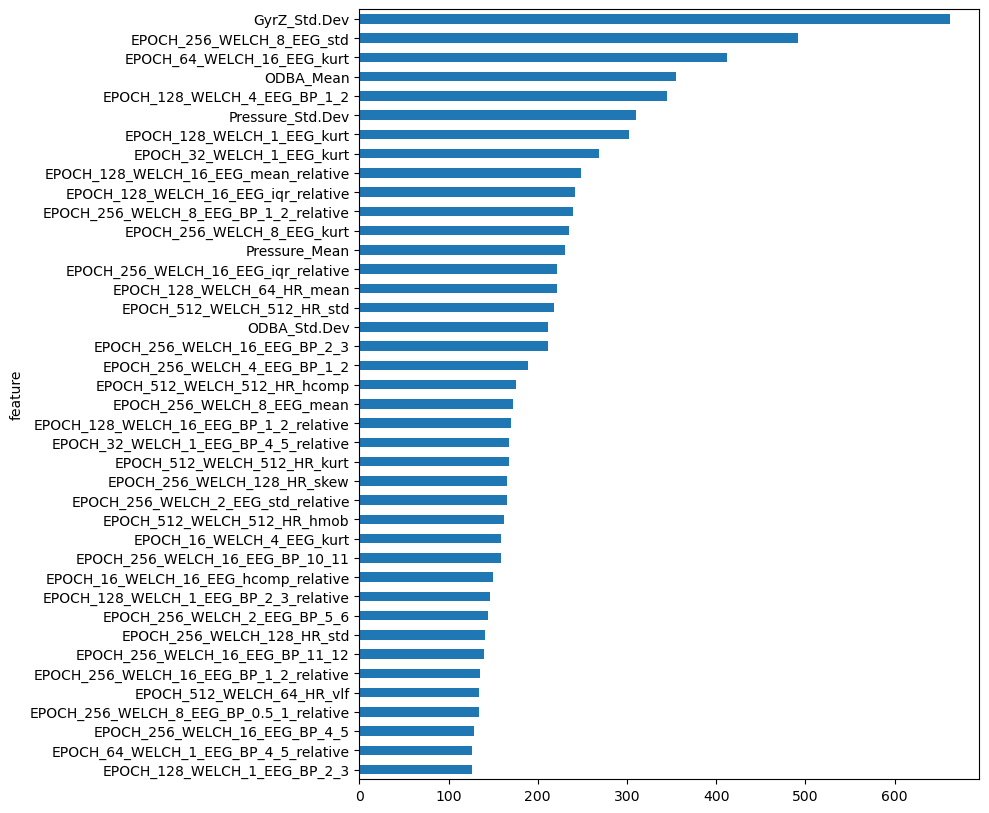

In [13]:
top_40 = feat_importances_all_combined.sort_values(ascending=False).iloc[:40]
feat_imp_plot = top_40.sort_values().plot(kind='barh', figsize=(8, 10))

## all features with 0 contribution

In [14]:
bottom_features = feat_importances_all_combined[feat_importances_all_combined == 0]
bottom_features = bottom_features.sort_index().index.values
for i in range(5 - (len(bottom_features) % 5)):
    bottom_features = np.append(bottom_features, np.nan)
bottom_features = pd.DataFrame(bottom_features.reshape((-1, 5)))
bottom_features.to_csv('../data/processed/v3_features/unused_features.csv')

## aggregated by welch window, epoch window, frequency range, and other features

In [29]:
feat_importances_all_combined = pd.read_csv(
    '../data/processed/v3_features/Wednesday_feature_importance_v3.csv',
    index_col=0
)['feature_importance']

In [19]:
def append_zeroes_to_shorter_columns(df_dict):
    max_length = max(len(arr) for arr in df_dict.values())

    # Iterate through the dictionary and append zeros to shorter arrays
    for key, arr in df_dict.items():
        while len(arr) < max_length:
            arr.append(0)

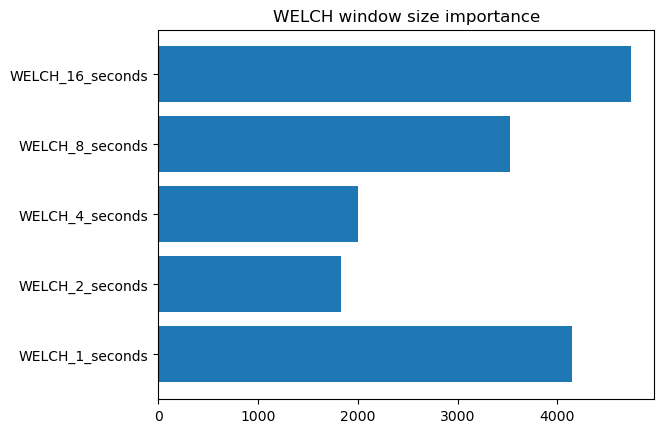

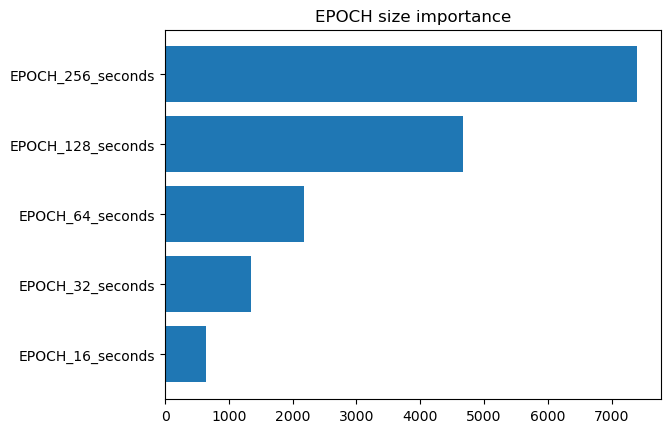

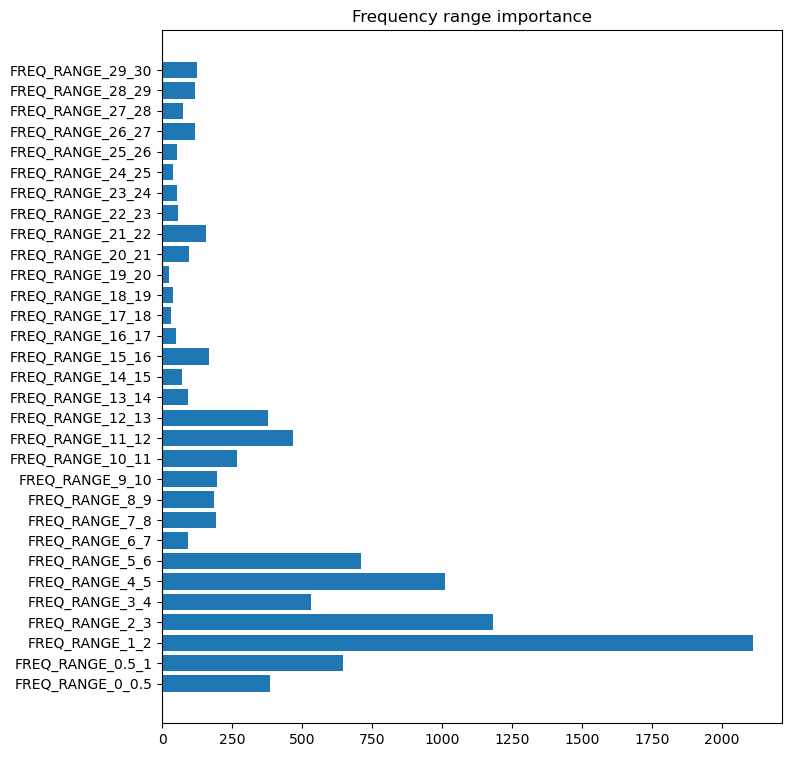

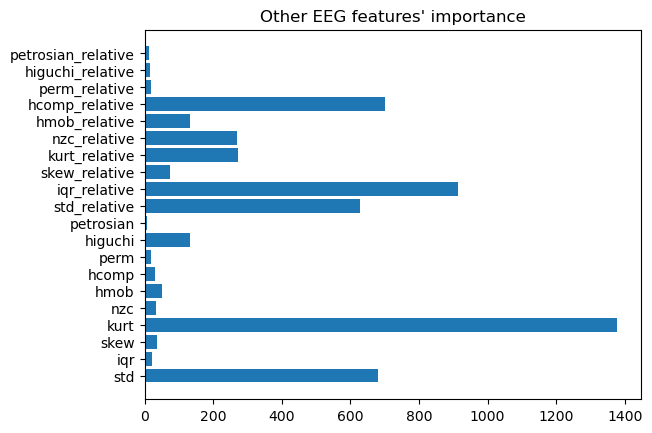

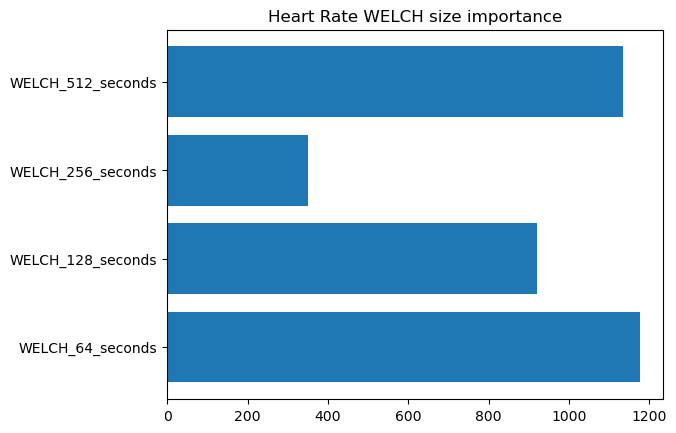

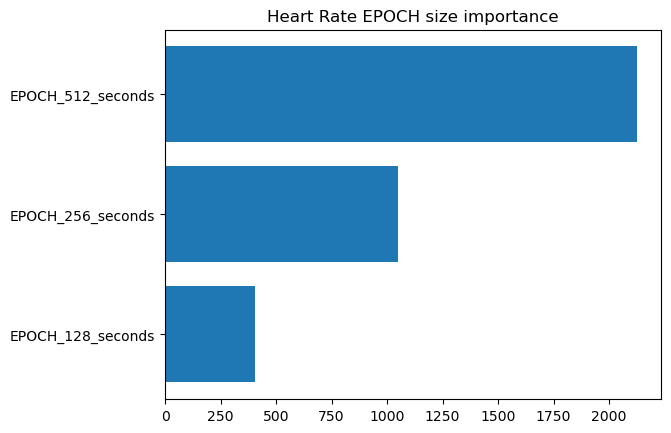

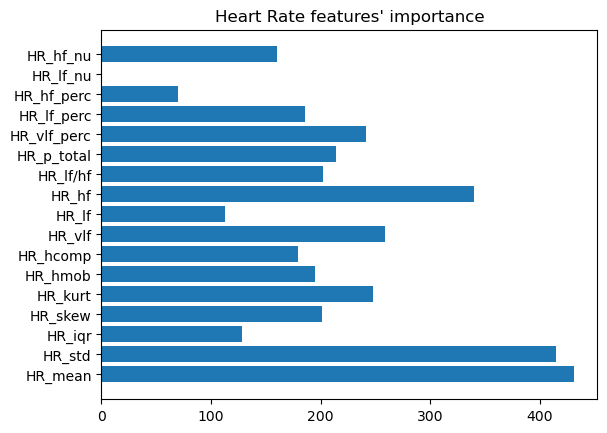

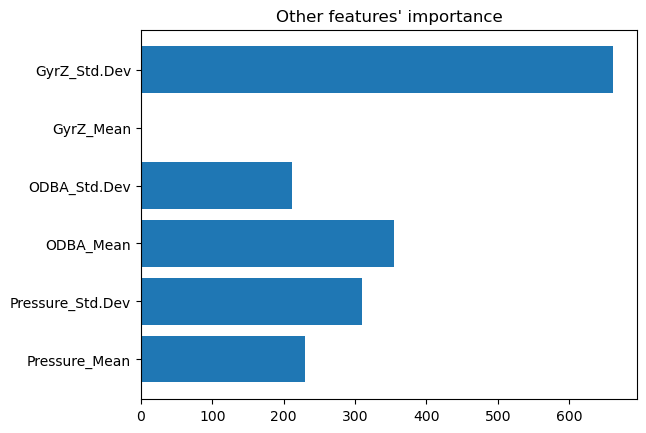

In [34]:
# Build dictionaries for each category
eeg_welch_importances_agg = {
    welch_num: [] for welch_num in [1, 2, 4, 8, 16]
}
hr_welch_importances_agg = {
    welch_num: [] for welch_num in [64, 128, 256, 512]
}
eeg_epoch_importances_agg = {
    epoch_num: [] for epoch_num in [16, 32, 64, 128, 256]
}
hr_epoch_importances_agg = {
    epoch_num: [] for epoch_num in [128, 256, 512]
}
eeg_freq_range_agg = {
    freq_range: [] for freq_range in ['0_0.5', '0.5_1'] + [f'{i}_{i+1}' for i in range(1,30)]
}
hr_features = ['HR_mean', 'HR_std', 'HR_iqr', 'HR_skew', 'HR_kurt', 'HR_hmob', 'HR_hcomp', 'HR_vlf',
               'HR_lf', 'HR_hf', 'HR_lf/hf', 'HR_p_total', 'HR_vlf_perc', 'HR_lf_perc', 'HR_hf_perc',
               'HR_lf_nu', 'HR_hf_nu']
hr_importances_agg = {
    hr_feature: [] for hr_feature in hr_features
}
# Other EEG features
other_eeg_feature_names = ['std', 'iqr', 'skew', 'kurt', 'nzc', 'hmob', 'hcomp', 'perm', 'higuchi', 'petrosian']
other_eeg_features_agg = {
    other_feature: [] for other_feature in other_eeg_feature_names
}
for other_feature in other_eeg_feature_names:
    other_eeg_features_agg[f'{other_feature}_relative'] = []

# Non-eeg features
other_feature_names = [other_feature.replace(' ', '_') for other_feature in
                       ['Pressure Mean', 'Pressure Std.Dev', 'ODBA Mean', 'ODBA Std.Dev',
                        'GyrZ Mean', 'GyrZ Std.Dev']]
other_features_agg = {
    other_feature: [] for other_feature in other_feature_names
}

# Append feature importances to each category
for feature, importance in feat_importances_all_combined.items():
    if 'WELCH' in feature:
        welch_num = int(re.findall('WELCH_[0-9]+', feature)[0][6:])
        if 'HR_' in feature:
            hr_welch_importances_agg[welch_num].append(importance)
        else:
            eeg_welch_importances_agg[welch_num].append(importance)
    if 'EPOCH' in feature:
        epoch_num = int(re.findall('EPOCH_[0-9]+', feature)[0][6:])
        if 'HR_' in feature:
            hr_epoch_importances_agg[epoch_num].append(importance)
        else:
            eeg_epoch_importances_agg[epoch_num].append(importance)
    for freq_range in eeg_freq_range_agg.keys():
        if '_' + freq_range in feature:
            eeg_freq_range_agg[freq_range].append(importance)
    for other_eeg_feature in other_eeg_feature_names:
        if other_eeg_feature in feature and 'HR' not in feature:
            if 'relative' in feature:
                other_eeg_features_agg[f'{other_eeg_feature}_relative'].append(importance)
            else:
                other_eeg_features_agg[f'{other_eeg_feature}'].append(importance)
    for other_feature in other_feature_names:
        if other_feature == feature:
            other_features_agg[other_feature].append(importance)
    if 'HR_' in feature:
        for hr_feature in hr_features:
            hr_feature_extracted = re.findall('HR_.*', feature)[0]
            if hr_feature == hr_feature_extracted:
                hr_importances_agg[hr_feature].append(importance)

# DataFrame of each category feature importance distributions

# Make all df_dicts have the same length for each columns
for df_dict in [eeg_welch_importances_agg,
                eeg_epoch_importances_agg,
                eeg_freq_range_agg,
                other_eeg_features_agg,
                hr_welch_importances_agg,
                hr_epoch_importances_agg,
                hr_importances_agg,
                other_features_agg]:
    append_zeroes_to_shorter_columns(df_dict)
    
eeg_welch_importance_df = pd.DataFrame(eeg_welch_importances_agg)
eeg_epoch_importance_df = pd.DataFrame(eeg_epoch_importances_agg)
eeg_freq_range_importance_df = pd.DataFrame(eeg_freq_range_agg)
other_eeg_feature_df = pd.DataFrame(other_eeg_features_agg)
hr_welch_importance_df = pd.DataFrame(hr_welch_importances_agg)
hr_epoch_importance_df = pd.DataFrame(hr_epoch_importances_agg)
hr_features_df = pd.DataFrame(hr_importances_agg)
other_features_df = pd.DataFrame(other_features_agg)

eeg_welch_importance_df.columns = [f'WELCH_{col}_seconds' for col in eeg_welch_importance_df.columns]
eeg_epoch_importance_df.columns = [f'EPOCH_{col}_seconds' for col in eeg_epoch_importance_df.columns]
eeg_freq_range_importance_df.columns = [f'FREQ_RANGE_{col}' for col in eeg_freq_range_importance_df.columns]
hr_welch_importance_df.columns = [f'WELCH_{col}_seconds' for col in hr_welch_importance_df.columns]
hr_epoch_importance_df.columns = [f'EPOCH_{col}_seconds' for col in hr_epoch_importance_df.columns]


# Make plots ---
# EEG welch
plt.barh(width=eeg_welch_importance_df.sum(), y=eeg_welch_importance_df.columns)
plt.title('WELCH window size importance')
plt.show()
# EEG epoch
plt.barh(width=eeg_epoch_importance_df.sum(), y=eeg_epoch_importance_df.columns)
plt.title('EPOCH size importance')
plt.show()
# EEG freq ranges
plt.barh(width=eeg_freq_range_importance_df.sum(), y=eeg_freq_range_importance_df.columns,
         figure=plt.figure(figsize=(8, 9)))
plt.title('Frequency range importance')
plt.show()
# EEG other features
plt.barh(width=other_eeg_feature_df.sum(), y=other_eeg_feature_df.columns)
plt.title('Other EEG features\' importance')
plt.show()
# Heart Rate welch
plt.barh(width=hr_welch_importance_df.sum(), y=hr_welch_importance_df.columns)
plt.title('Heart Rate WELCH size importance')
plt.show()
# Heart Rate epoch
plt.barh(width=hr_epoch_importance_df.sum(), y=hr_epoch_importance_df.columns)
plt.title('Heart Rate EPOCH size importance')
plt.show()
# Heart Rate other
plt.barh(width=hr_features_df.sum(), y=hr_features_df.columns)
plt.title('Heart Rate features\' importance')
plt.show()
# Movement & Pressure (and old heart rate features)
plt.barh(width=other_features_df.sum(), y=other_features_df.columns)
plt.title('Other features\' importance')
plt.show()

## End of feature discovery

---
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

---
## Plotting code
| &nbsp; | &nbsp; | &nbsp; |<br>
v &nbsp;v &nbsp;v &nbsp;v

---

# Other: plotting code

In [ ]:
colormap = {
    'Awake': 'lightcoral',
    'SW1': 'green',
    'SW2': 'cyan',
    'REM': 'gold',
    'Drowsy': 'mediumpurple'
}

# Load EEG Data
start_seconds = int((df['R.Time'].iloc[0] - recording_start_datetime).total_seconds())
end_seconds = int((df['R.Time'].iloc[-1] - recording_start_datetime).total_seconds())
eeg_data = raw.get_data('EEG_ICA5')[0].copy()
start_index = int(start_seconds * 500)
end_index = int(end_seconds * 500)
eeg_data = eeg_data[start_index:end_index]

# Load model data and predictions
pst_timezone = pytz.timezone('America/Los_Angeles')
model_data_v3 = pd.read_csv('../data/processed/v3_features/Wednesday_all_features_with_labels_v3.csv',
                            index_col=0)
model_data_v3.index = pd.DatetimeIndex(model_data_v3.index, tz=pst_timezone)


# Plot nap function
def plot_nap(nap_start_dt, nap_end_dt):
    eeg_start_idx = int((nap_start_dt - model_data_v3.index[0]).total_seconds() * 500)
    eeg_end_idx = int((nap_end_dt - model_data_v3.index[0]).total_seconds() * 500)
    fig, ax = plt.subplots(5, 1, figsize=(9, 8))
    nap_df = model_data_v3[(model_data_v3.index >= nap_start_dt) &
                           (model_data_v3.index <= nap_end_dt)]
    print(eeg_start_idx, eeg_end_idx)
    eeg_nap = eeg_data[eeg_start_idx:eeg_end_idx]
    preds_nap = preds_model_v3[(preds_model_v3.index >= nap_start_dt) &
                               (preds_model_v3.index <= nap_end_dt)]
    simple_sleep_codes = ['Unscorable', 'Active Waking', 'Quiet Waking', 'Drowsiness', 'SWS', 'REM']
    
    add_vals_dt = pd.date_range(nap_start_dt - datetime.timedelta(seconds=len(simple_sleep_codes)),
                                nap_start_dt, freq='s', inclusive='left')
    add_vals = pd.Series(simple_sleep_codes, index=add_vals_dt)
    preds_nap = pd.concat([add_vals, preds_nap])
    labels_nap = pd.concat([add_vals, nap_df['Simple.Sleep.Code']])
    # print('duration (seconds):', np.sum((preds.index >= nap_start_dt) & (preds.index <= nap_end_dt)))
    # Labels
    sns.lineplot(labels_nap, ax=ax[0], color='black')
    ax[0].set_ylabel('True\nLabel')
    ax[0].yaxis.tick_right()
    ax[0].set_xlim([labels_nap.index[len(simple_sleep_codes)], labels_nap.index[len(labels_nap) - 1]])
    
    # Predictions
    sns.lineplot(preds_nap, ax=ax[1], color='purple')
    ax[1].set_ylabel('Predicted\nLabel')
    ax[1].yaxis.tick_right()
    ax[1].set_xlim([preds_nap.index[len(simple_sleep_codes)], preds_nap.index[len(preds_nap) - 1]])
    
    epoch = 128
    welch = 16
    # Delta Power
    bp_str = f'EPOCH_{epoch}_WELCH_{welch}'
    delta_power = (nap_df[f'{bp_str}_BP_0.5_1'] + nap_df[f'{bp_str}_BP_0.5_1'] + 
                   nap_df[f'{bp_str}_BP_1_2'] + nap_df[f'{bp_str}_BP_2_3'] +
                   nap_df[f'{bp_str}_BP_3_4'])
    sns.lineplot(delta_power, ax=ax[2], color='lightgreen')
    ax[2].set_ylabel('Delta Power')
    
    # EEG
    eeg_fig = sns.lineplot(eeg_nap, linewidth = 0.25, ax=ax[3], color='green')
    # plot two standard deviations from median ..?
    eeg_median, eeg_std = np.median(eeg_nap), np.std(eeg_nap)
    print(eeg_median, eeg_std)
    ax[3].set_ylabel('EEG')
    # Heart rate
    sns.lineplot(nap_df['EPOCH_128_WELCH_64_HR_mean'].rename('HR mean (128 sec)'), ax=ax[4], color='lightcoral')
    # Pressure
    #sns.lineplot(nap_df['Pressure Mean'], ax=ax[5], color='lightblue')
    for i in range(len(ax) - 1):
        ax[i].set_xticks([])
        ax[i].set_xlabel('')
    ax[3].set_ylim(-7e-5, 7e-5)
    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()

In [ ]:
nap1 = (
    datetime.datetime.strptime('10/25/2019 16:36:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone),
    datetime.datetime.strptime('10/25/2019 16:50:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone)
)
plot_nap(nap1[0], nap1[1])


In [ ]:
nap2 = (
    datetime.datetime.strptime('10/25/2019 17:26:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone),
    datetime.datetime.strptime('10/25/2019 17:37:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone)
)
plot_nap(nap2[0], nap2[1])
